In [ ]:
# Importing all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# trying isolation forest 
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
merged_df = pd.read_csv('merged_df_Combined.csv')

In [3]:
correlations = merged_df.drop(columns=['Datetime']).corrwith(merged_df['System_Price']).abs().sort_values(ascending = False)
correlations[:12]

System_Price            1.000000
Intraday_Price          0.810647
Day_Ahead_Price         0.685809
NIV_Outturn             0.327428
BSAD_Total              0.270154
BM_Bid_Acceptances      0.231037
BSAD_Turn_Down          0.228765
Nuclear                 0.201872
Demand_Outturn          0.172817
Hydro_Pumped_Storage    0.165744
Fossil_Gas              0.138025
BSAD_Turn_Up            0.132108
dtype: float64

Since the first three are price data, stuff we can't predic

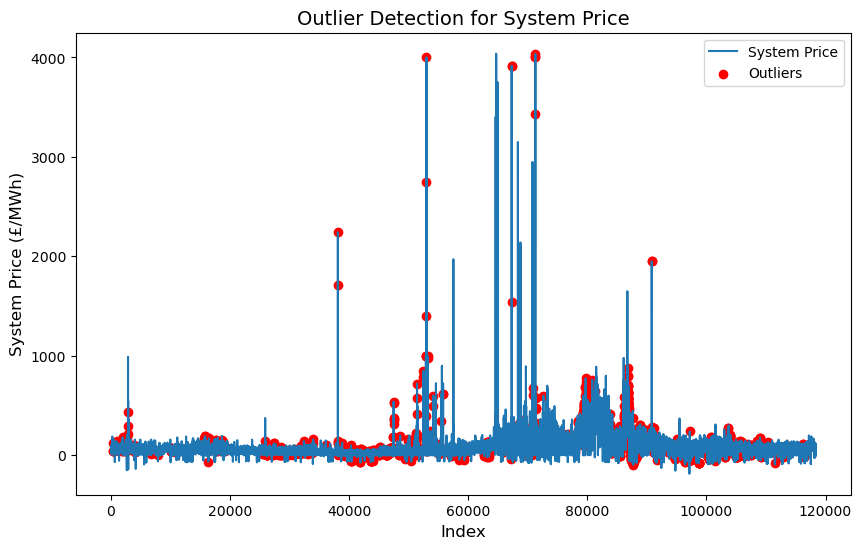

In [ ]:
# using the top features only but ideally it would be best to use the final features used for the classification
top_features = correlations.abs().sort_values(ascending=False).iloc[3:13].index.tolist()
print("The features we will be using are", top_features)
# scaling because you need to for isolation forest 
data_to_scale = merged_df[top_features]

# Assuming `data` is your dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)  # Scaled dataset
iso_forest = IsolationForest(
    n_estimators=1000, 
    contamination=0.02,  # Adjust based on expected proportion of anomalies
    random_state=42
)
# Predict outliers
iso_forest.fit(scaled_data)
predictions = iso_forest.predict(scaled_data)

# Anomaly scores (lower scores indicate more anomalous points)
anomaly_scores = iso_forest.decision_function(scaled_data)

# Add predictions and scores to your dataframe
merged_df['anomaly'] = predictions
merged_df['anomaly_score'] = anomaly_scores

In [ ]:
# Calculate thresholds for outliers
lower_threshold = merged_df['System_Price'].quantile(0.01)
upper_threshold = merged_df['System_Price'].quantile(0.99)

# Label true outliers based on thresholds
merged_df['True_Upward_Outlier'] = (merged_df['System_Price'] > upper_threshold).astype(int)
merged_df['True_Downward_Outlier'] = (merged_df['System_Price'] < lower_threshold).astype(int)

# Predicted outliers
merged_df['Predicted_Outlier'] = (merged_df['anomaly'] == -1).astype(int)

# Upward Outliers
upward_precision = precision_score(merged_df['True_Upward_Outlier'], merged_df['Predicted_Outlier'])
upward_recall = recall_score(merged_df['True_Upward_Outlier'], merged_df['Predicted_Outlier'])
upward_f1 = f1_score(merged_df['True_Upward_Outlier'], merged_df['Predicted_Outlier'])

# Downward Outliers
downward_precision = precision_score(merged_df['True_Downward_Outlier'], merged_df['Predicted_Outlier'])
downward_recall = recall_score(merged_df['True_Downward_Outlier'], merged_df['Predicted_Outlier'])
downward_f1 = f1_score(merged_df['True_Downward_Outlier'], merged_df['Predicted_Outlier'])

# Print results
print("Upward Outliers - Precision:", upward_precision, "Recall:", upward_recall, "F1-Score:", upward_f1)
print("Downward Outliers - Precision:", downward_precision, "Recall:", downward_recall, "F1-Score:", downward_f1)


Upward Outliers - Precision: 0.07224334600760456 Recall: 0.1445477599323753 F1-Score: 0.09633802816901409
Downward Outliers - Precision: 0.050697084917617236 Recall: 0.10135135135135136 F1-Score: 0.06758659532526048


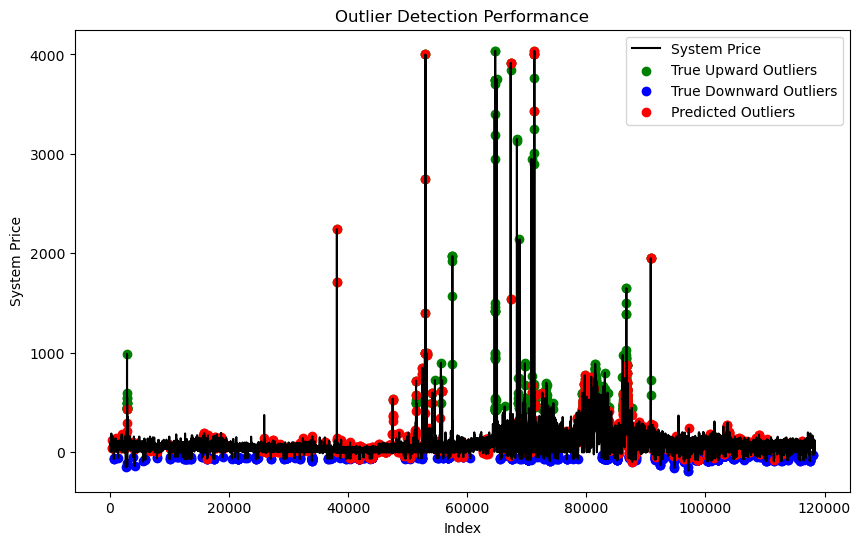

In [28]:
plt.figure(figsize=(10, 6))

# Plot System_Price
plt.plot(merged_df['System_Price'], label='System Price', color='black')

# Highlight true upward and downward outliers
plt.scatter(merged_df.index[merged_df['True_Upward_Outlier'] == 1], 
            merged_df['System_Price'][merged_df['True_Upward_Outlier'] == 1], 
            color='green', label='True Upward Outliers')

plt.scatter(merged_df.index[merged_df['True_Downward_Outlier'] == 1], 
            merged_df['System_Price'][merged_df['True_Downward_Outlier'] == 1], 
            color='blue', label='True Downward Outliers')

# Highlight predicted outliers
plt.scatter(merged_df.index[merged_df['Predicted_Outlier'] == 1], 
            merged_df['System_Price'][merged_df['Predicted_Outlier'] == 1], 
            color='red', label='Predicted Outliers')

# Add title and legend
plt.title('Outlier Detection Performance')
plt.xlabel('Index')
plt.ylabel('System Price')
plt.legend()
plt.show()


In [29]:
# Count true positives, false positives, and false negatives
true_positives = merged_df[(merged_df['Predicted_Outlier'] == 1) & 
                           ((merged_df['True_Upward_Outlier'] == 1) | (merged_df['True_Downward_Outlier'] == 1))]

false_positives = merged_df[(merged_df['Predicted_Outlier'] == 1) & 
                            (merged_df['True_Upward_Outlier'] == 0) & (merged_df['True_Downward_Outlier'] == 0)]

false_negatives = merged_df[(merged_df['Predicted_Outlier'] == 0) & 
                            ((merged_df['True_Upward_Outlier'] == 1) | (merged_df['True_Downward_Outlier'] == 1))]

print("True Positives:", len(true_positives))
print("False Positives:", len(false_positives))
print("False Negatives:", len(false_negatives))


True Positives: 291
False Positives: 2076
False Negatives: 2076
